# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

  Using cached networkx-2.1-py2.py3-none-any.whl
  Using cached decorator-5.1.0-py3-none-any.whl (9.1 kB)


In [2]:
nx.__version__ # should be 2.1
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [12]:


import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
from sklearn.neighbors import KDTree
import planning 
from planning import Sampler 
from planning import a_star_graph



In [4]:
plt.rcParams['figure.figsize'] = 14, 14

## Step 1 - Load Data

In [5]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Step 2 - Sample Points


You may want to limit the z-axis values.

In [6]:

sampler = Sampler(data)
polygons = sampler.extract_polygons()
n_samples = 300 
valid_samples = sampler.sample(n_samples)                   
print(len(valid_samples))

207


## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [7]:

# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!
    
def can_connect(node1, node2, polygons):
    # p1, p2 : coordinates in tuple 
    
    # make a line using shapely    
    line = LineString([node1, node2])
    
    for p, height in polygons:
        if p.crosses(line) and height >= min(node1[2], node2[2]):
            return False 
    
    return True     
    
def create_graph(nodes, polygons, k):
    g = nx.Graph()
    tree = KDTree(np.array(nodes))
    
    for node in nodes:
        
        # pick k cloest nodes to the current node 
        # and return the idxs of them 
        idxs = tree.query(np.array([node]), k)[1][0]
        
        for i in idxs:
            
            if node == nodes[i]:
                continue 
            
            # can they be connected without collision?  
            if can_connect(node, nodes[i], polygons):
                dist = np.linalg.norm(np.array(node) - np.array(nodes[i]))
                g.add_edge(node, nodes[i], weight = dist)
                               
    return g       
   
g= create_graph(valid_samples, polygons, 10)        
print(len(g.edges))


571


## Step 4 - Visualize Graph

207
190


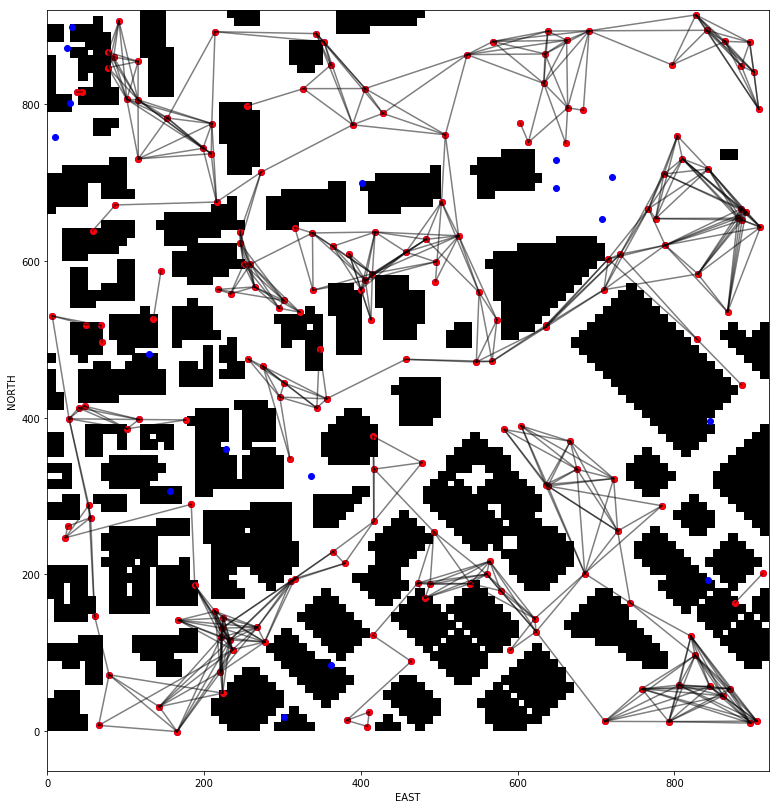

In [10]:
# Create a grid map of the world
from grid import create_grid
# This will create a grid map at z_max m above ground level
grid = create_grid(data, sampler._z_max, 1)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw all edges of the graph
for (n1, n2) in g.edges:
   plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
nodes = valid_samples
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
print(len(nodes))    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
print(len(g.nodes))

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

## Step 5 - Define Heuristic

In [11]:
def heuristic(n1, n2):
    # Euclidean distance 
    h = np.linalg.norm(np.array(n1) - np.array(n2))
    return h

## Step 6 - Complete A*

In [38]:
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    # list - nodes of path (found optimal path)
    # queue - total cost(branch cost + heuristic cost) and current expandible nodes  
    # set - visited nodes 
    # dictionary - next node, corresponding current node and branch cost so far 
    
    path = []
    path_cost = 0 # branch cost for the total path 
    
    queue = PriorityQueue()
    visited = set(start)
    branch = {}
    
    queue.put((0, start))
    found = False 
    
    while not queue.empty():
         
         item = queue.get()
         current_node = item[1]
         
         if current_node == start:
             current_cost = 0.0 
         else:
             current_cost = branch[current_node][0]  
             
         if current_node == goal:
             found = True 
             break 
         
         else:    
    
            for next_node in graph[current_node]:
                
                branch_cost = current_cost + graph.edges[current_node, next_node]['weight']
                heuristic_cost = heuristic(next_node, goal)
                queue_cost = branch_cost + heuristic_cost
                
                if next_node not in visited:
                
                    queue.put((queue_cost, next_node))
                    branch[next_node] = (branch_cost, current_node)
                    visited.add(next_node)
        
    
    if found:
        
        path_cost = branch[goal][0]
        path.append(goal)
        n = goal 
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    
    else:
        print("Failed to find a path")        
    
    
    
    return path[::-1], path_cost 



## Step 7 - Visualize Path

In [41]:
start = list(g.nodes)[0]
k = np.random.randint(len(g.nodes))
print(k, len(g.nodes))
goal = list(g.nodes)[77]

#path, cost = a_star(g, heuristic, start, goal)
path, cost = a_star_graph(g, heuristic, start, goal)
print(len(path), path)


fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'grey')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'blue')


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

56 190
Failed to find a path 
0 []


[solution](/notebooks/Probabilistic-Roadmap-Solution.ipynb)